In [1]:
import os
import numpy as np

import tensorflow as tf
from tensorflow import keras

print(tf.__version__, np.__version__)

# Expected output 2.9.0, 1.26.4

2.9.0 1.26.4


## Detect GPU and limit GPU memory usage if exist

In [2]:
USE_GPU = True

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus != []:
    print(gpus)
    for gpu in gpus: 
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("No GPU on this machine")

# Expected output [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
if USE_GPU == False:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [5]:
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

GPU found


# Model selector

In [6]:
INPUT_SHAPE = (224,224,3)
base_model = tf.keras.applications.ResNet152V2(input_shape=INPUT_SHAPE, include_top=False, weights='imagenet')
model_name = "ResNet152V2"

# Load data

In [7]:
import numpy as np
from matplotlib import pyplot as plt

data_dir = r"C:\Users\kanan\Desktop\data_x\data_x\train"
data = tf.keras.utils.image_dataset_from_directory(data_dir, image_size=(224, 224))

# Expected output Found 39703 files belonging to 2 classes.

Found 39703 files belonging to 2 classes.


In [8]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

# Split Train/Val

In [9]:
train_size = int(len(data)*.8)
val_size = int(len(data)*.2)

In [10]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)

# Build model

In [11]:
# True = Training the base model

TRAIN_FULL_NETWROK = False

In [12]:
IMG_DIM = (224,224)

In [13]:
base_model.trainable = TRAIN_FULL_NETWROK

In [14]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [15]:
inputs = tf.keras.Input(shape=INPUT_SHAPE)

x = base_model(inputs, training=TRAIN_FULL_NETWROK)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)

# A Dense classifier with a single unit (binary classification)
outputs = Dense(1, activation='sigmoid')(x)
model = Model(inputs=inputs, outputs=outputs)

In [16]:
import pandas as pd

pd.set_option('max_colwidth', None)
layers = [(layer, layer.name, layer.trainable) for layer in model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x000002386965B880>,input_2,True
1,<keras.engine.functional.Functional object at 0x0000023867AA4220>,resnet152v2,False
2,<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x000002386965B340>,global_average_pooling2d,True
3,<keras.layers.core.dense.Dense object at 0x00000236B668D7B0>,dense,True
4,<keras.layers.core.dense.Dense object at 0x000002386965ACE0>,dense_1,True
5,<keras.layers.core.dense.Dense object at 0x00000238697516F0>,dense_2,True


In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 1)                 513       
                                                             

In [18]:
model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=False), # change from_logits=True
              optimizer= keras.optimizers.Adam(learning_rate=1e-2),
              metrics = [keras.metrics.BinaryAccuracy()])

# Set up training metrics

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

In [20]:
dir_path = r"C:\Users\kanan\Desktop\data_x"

results_dir = "logs\\" + model_name
results_dir = os.path.join(dir_path, results_dir)

models_dir = "models\\" + model_name
models_dir = os.path.join(dir_path, models_dir)

if not os.path.isdir(results_dir):
    os.makedirs(results_dir)
    
if not os.path.isdir(models_dir):
    os.makedirs(models_dir)

In [21]:
log_file = os.path.join(results_dir, f"{model_name}_bo20_lr001.csv")

In [22]:
callbacks = [
    CSVLogger(log_file),
    ModelCheckpoint(
        filepath=os.path.join(models_dir, f"{model_name}_bo20_lr001.h5"),
        save_weights_only=False,
        save_best_only=True,
        save_freq='epoch',
        verbose=1
    )
]

# Train model

In [23]:
history = model.fit(train, 
                    validation_data=val,
                    epochs=20, 
                    verbose=1, 
                    callbacks=callbacks)

Epoch 1/20
992/992 [==============================] - ETA: 0s - loss: 25.7293 - binary_accuracy: 0.5275
Epoch 1: val_loss improved from inf to 0.69242, saving model to C:\Users\kanan\Desktop\data_x\models\ResNet152V2\ResNet152V2_bo20_lr001.h5
992/992 [==============================] - 333s 325ms/step - loss: 25.7293 - binary_accuracy: 0.5275 - val_loss: 0.6924 - val_binary_accuracy: 0.5252
Epoch 2/20
992/992 [==============================] - ETA: 0s - loss: 0.6916 - binary_accuracy: 0.5305
Epoch 2: val_loss did not improve from 0.69242
992/992 [==============================] - 333s 336ms/step - loss: 0.6916 - binary_accuracy: 0.5305 - val_loss: 0.6924 - val_binary_accuracy: 0.5253
Epoch 3/20
992/992 [==============================] - ETA: 0s - loss: 0.6916 - binary_accuracy: 0.5303
Epoch 3: val_loss improved from 0.69242 to 0.69215, saving model to C:\Users\kanan\Desktop\data_x\models\ResNet152V2\ResNet152V2_bo20_lr001.h5
992/992 [==============================] - 335s 338ms/step - l

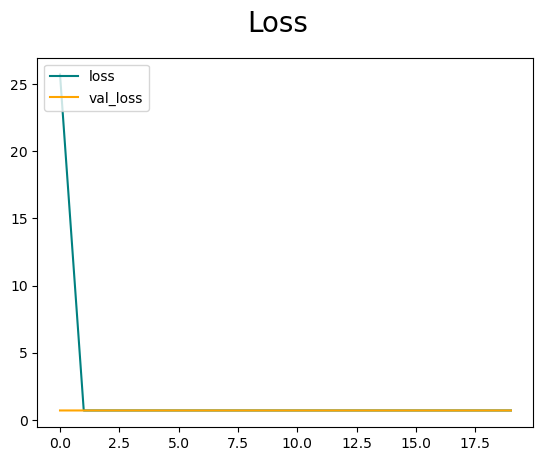

In [24]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Reducing learning rate from 0.01 to 0.001 and continue

Load model

In [25]:
from tensorflow.keras.models import load_model


saved_model_path = os.path.join(models_dir, f"{model_name}_bo20_lr001.h5")
new_model = load_model(saved_model_path)

Set new learning rate

In [26]:
current_optimizer = new_model.optimizer
current_lr = current_optimizer.learning_rate.numpy()

print(f"Old learning rate: {current_lr}")

Old learning rate: 0.009999999776482582


In [27]:
new_model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=False), 
              optimizer= keras.optimizers.Adam(learning_rate=1e-3),
              metrics = [keras.metrics.BinaryAccuracy()])

In [28]:
current_optimizer = new_model.optimizer
current_lr = current_optimizer.learning_rate.numpy()

print(f"New learning rate: {current_lr}")

New learning rate: 0.0010000000474974513


Continue training

In [29]:
log_file = os.path.join(results_dir, f"{model_name}_bo20_lr0001.csv")

In [30]:
callbacks = [
    CSVLogger(log_file),
    ModelCheckpoint(
        filepath=os.path.join(models_dir,f"{model_name}_bo20_lr0001.h5"),
        save_weights_only=False,
        save_best_only=True,
        save_freq='epoch',
        verbose=1
    )
]

In [31]:
print("")

In [32]:
history = new_model.fit(train, 
                    validation_data=val,
                    epochs=20, 
                    verbose=1, 
                    callbacks=callbacks)

Epoch 1/20
992/992 [==============================] - ETA: 0s - loss: 0.6913 - binary_accuracy: 0.5306
Epoch 1: val_loss improved from inf to 0.69193, saving model to C:\Users\kanan\Desktop\data_x\models\ResNet152V2\ResNet152V2_bo20_lr0001.h5
992/992 [==============================] - 345s 341ms/step - loss: 0.6913 - binary_accuracy: 0.5306 - val_loss: 0.6919 - val_binary_accuracy: 0.5256
Epoch 2/20
992/992 [==============================] - ETA: 0s - loss: 0.6913 - binary_accuracy: 0.5305
Epoch 2: val_loss improved from 0.69193 to 0.69177, saving model to C:\Users\kanan\Desktop\data_x\models\ResNet152V2\ResNet152V2_bo20_lr0001.h5
992/992 [==============================] - 338s 341ms/step - loss: 0.6913 - binary_accuracy: 0.5305 - val_loss: 0.6918 - val_binary_accuracy: 0.5267
Epoch 3/20
992/992 [==============================] - ETA: 0s - loss: 0.6913 - binary_accuracy: 0.5306
Epoch 3: val_loss did not improve from 0.69177
992/992 [==============================] - 337s 340ms/step - l

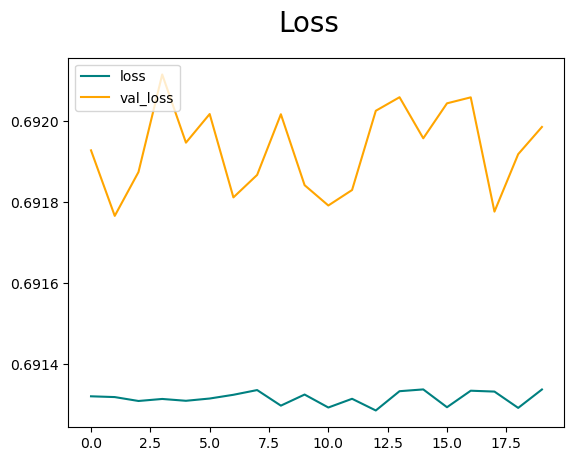

In [33]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Test

Load model

In [34]:
from tensorflow.keras.models import load_model

saved_model_path = os.path.join(models_dir, f"{model_name}_bo20_lr0001.h5")
test_model = load_model(saved_model_path)

Set measurement metrics

In [35]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

pre = Precision()
re = Recall()
acc = BinaryAccuracy()

Load data

In [36]:
import numpy as np
from matplotlib import pyplot as plt

data_dir = r"C:\Users\kanan\Desktop\data_x\data_x\test"
test = tf.keras.utils.image_dataset_from_directory(data_dir, image_size=(224, 224))

# Expected output Found 7360 files belonging to 2 classes.

Found 7360 files belonging to 2 classes.


Testing

In [37]:
test_iterator = test.as_numpy_iterator()
batch = test_iterator.next()

In [38]:
for batch in test_iterator: 
    X, y = batch
    yhat = test_model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 36ms/step


Test results

In [39]:
f1_score = 2 * (pre.result() * re.result()) / (pre.result() + re.result())
print(f"Precision : {pre.result().numpy()}")
print(f"Recall : {re.result().numpy()}")
print(f"Accuracy : {acc.result().numpy()}")
print(f"F1 Score : {f1_score.numpy()}")

Precision : 0.6151746511459351
Recall : 1.0
Accuracy : 0.6151746511459351
F1 Score : 0.7617438435554504
